In [1]:
import io
import os
import pickle
import random as rn
import warnings
from importlib import reload
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from IPython.display import display
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import models
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Extracting the data

In [2]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [3]:
path_to_preprocessed_train_docs = "train/preprocessed_docs.pkl"
# path_to_preprocessed_train_docs = "train/preprocessed_docs_tokenization_only.pkl"

with open(path_to_preprocessed_train_docs, "rb") as f:
    preprocessed_train_docs = pickle.load(f)

# preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
# with open(path_to_preprocessed_train_docs, "wb") as f:
#     pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

toronto stock end high volatile session change change tse 5900.37 +50.15 hi 5900.37 lo 5840.29 dji 6611.05 +27.57 gold london us$ 350.00 +1.90 ftse100 4248.10 -64.80 gold ny comex us$ 354.80 +0.70 nikkei 17869.59 -133.81 lme cash nickel us$ 7659 +99.0 candlr 1.3883 lme cash alum us$ 1602.0 -4.0 30-yr 107.41 -0.15 brent crude us$ 19.09 -0.27 --------------------market comment---------------------------- toronto stock end higher tuesday buoy strength gold banking computer problem heavy trading bre x minerals hamper session 84 million share trade toronto key stock index end higher tuesday saga bre x minerals ltd indonesian gold find continue dominate canada big stock market tse 300 index climb 50.15 point close 5900.37 heavy turnover 84.07 million share worth c$ 1.4 billion overall market mix decline issue narrowly outpace advance 476 464 298 issue flat frantic trading bre x collapse tse computer trading system earlier day force exchange halt trading stock market close share calgary base 

## Representing the documents as token index sequences

In [4]:
docs = preprocessed_train_docs
n_vocabulary = None

In [5]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="", lower=False)
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index
if n_vocabulary is None:
    n_vocabulary = len(word_idx)

print(n_vocabulary)

648463


In [6]:
n_sequence = 512

sequences = tokenizer.texts_to_sequences(docs)
if n_sequence is None:
    n_sequence = max([len(s) for s in sequences])
sequence_lengths = [min(len(s), n_sequence) for s in sequences]
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2][:100])

512
(299773, 512)
[  1610     24     17     19   2090    436    114    114   6746 188917
 327927   4443 188917   5714 327928  21934 142487 232206    240    141
    492  16347 101127  42844 327929 327930    240   2564   2406    492
 188918  52097   2264 327931 160780   1386    263   1863    492 327932
 327933  17989 160781   1386    263  15720    492 327934  10896   7925
  94597  25805    914    407    492  30933  35331  24629  27525   1610
     24     17    700     37   3599    827    240    567    674    327
    617    162   2578   1520   4945   4521    436   3271      5      7
     20   1610    328     24     75     17    700     37   7262   2578
   1520   4945    151   1456    240    314    112   1549    488    198]


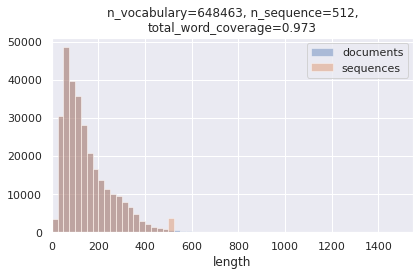

In [7]:
doc_lengths = [len(doc.split()) for doc in docs]

sns.distplot(doc_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="documents")
sns.distplot(sequence_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="sequences")
total_word_coverage = np.round(np.sum(sequence_lengths) / np.sum(doc_lengths), 3)
plt.title(f"n_vocabulary={n_vocabulary}, n_sequence={n_sequence},\n"
          f"total_word_coverage={total_word_coverage}")
plt.xlim(0, 1550)
plt.xlabel("length")
plt.legend()
plt.tight_layout()
plt.show()

## Word embeddings

In [8]:
n_embedding = 300 # 300 required by FastText

### FastText

In [9]:
reset_seed()

window = 5
ft_path = f"data/fasttext_{window}_{n_embedding}_train.model"

try:
    ft = FastText.load(ft_path)
except:
    ft = FastText(sentences=[doc.split() for doc in docs], size=n_embedding,
                  window=window, min_count=1, workers=cpu_count(), seed=seed)
    ft.save(ft_path)

print(len(list(ft.wv.vocab)))
print(ft.wv.index2entity[:100])

648463
['say', '$', 'percent', 'year', 'million', 'market', 'share', 'bank', 'company', 'new', 'price', 'n', 'rate', 'billion', 'government', 'u.s.', 'end', 'week', 'high', 'trade', 'month', 'rise', 'expect', 'stock', '1997', 'sale', 'june', '1', 'net', 'newsroom', 'group', 'pct', 'day', 'state', 'report', 'close', 'tuesday', '1996', 'wednesday', 'official', 'july', 'low', 'thursday', 'monday', 'point', 'friday', 'bond', 'plan', 'issue', 'minister', 'trader', 'fall', 'dollar', '2', 'tell', 'interest', 'profit', '=', 'vs', 'time', 'yen', 'income', 'loss', 'analyst', 'add', 'quarter', 'result', 'country', 'oil', 'total', 'president', 'firm', 'lead', 'april', 'index', 'cent', 'see', 'tonne', '10', 'march', 'include', 'foreign', 'increase', 'sell', 'hold', '30', 'business', 'dealer', 'note', 'central', 'second', 'people', 'european', 'tax', 'f', 'future', 'buy', 'term', 'follow', 'party']


### Word2Vec

In [11]:
reset_seed()

window = 5
w2v_path = f"data/w2v_{window}_{n_embedding}_train.model"

try:
    w2v = Word2Vec.load(w2v_path)
except:
    w2v = Word2Vec(sentences=[doc.split() for doc in docs], size=n_embedding,
                   window=window, min_count=1, workers=cpu_count(), seed=seed)
    w2v.save(w2v_path)

print(len(list(w2v.wv.vocab)))
print(w2v.wv.index2entity[:100])

648463
['say', '$', 'percent', 'year', 'million', 'market', 'share', 'bank', 'company', 'new', 'price', 'n', 'rate', 'billion', 'government', 'u.s.', 'end', 'week', 'high', 'trade', 'month', 'rise', 'expect', 'stock', '1997', 'sale', 'june', '1', 'net', 'newsroom', 'group', 'pct', 'day', 'state', 'report', 'close', 'tuesday', '1996', 'wednesday', 'official', 'july', 'low', 'thursday', 'monday', 'point', 'friday', 'bond', 'plan', 'issue', 'minister', 'trader', 'fall', 'dollar', '2', 'tell', 'interest', 'profit', '=', 'vs', 'time', 'yen', 'income', 'loss', 'analyst', 'add', 'quarter', 'result', 'country', 'oil', 'total', 'president', 'firm', 'lead', 'april', 'index', 'cent', 'see', 'tonne', '10', 'march', 'include', 'foreign', 'increase', 'sell', 'hold', '30', 'business', 'dealer', 'note', 'central', 'second', 'people', 'european', 'tax', 'f', 'future', 'buy', 'term', 'follow', 'party']


### Pre-trained FastText

In [12]:
def load_vectors(fname): # from https://fasttext.cc/docs/en/english-vectors.html
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

ft_pretrained = load_vectors("data/crawl-300d-2M.vec")

token_iter = iter(ft_pretrained)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was', 'are', 'or', 'this', 'as', 'have', 'at', 'from', '!', "'s", 'but', 'by', 'not', '?', 'your', 'all', '/', 'be', 'we', 'my', 'one', '-', 'will', 'they', 'so', 'which', '”', '“', 'has', '...', 'just', 'he', 'their', 'can', 'about', 'his', 'our', ';', 'when', 'more', 'had', 'do', 'some', 'time', 'like', 'also', 'there', 'them', 'get', 'what', 'out', "'", 'me', 'her', 'an', 'were', 'This', 'It', 'up', 'would', 'if', 'who', 'new', 'only', 'A', '–', 'people', 'any', 'We', 'make', 'other', 'In', 'then', 'its', 'use', 'said', 'now', 'no', 'first']


### Pre-trained GloVe

In [13]:
glove_pretrained = {}
f = open("data/glove.42B.300d.txt", errors = 'ignore', encoding='utf8')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    glove_pretrained[word] = coefs
f.close()

token_iter = iter(glove_pretrained)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', '"', 'is', 'for', ':', 'i', ')', 'that', '(', 'you', 'it', 'on', '-', 'with', "'s", 'this', 'by', 'are', 'at', 'as', 'be', 'from', 'have', 'was', 'or', 'your', 'not', '...', 'we', '!', 'but', '?', 'all', 'will', 'an', 'my', 'can', 'they', "n't", 'do', 'he', 'more', 'if', 'one', 'has', '|', 'so', 'about', 'new', 'what', 'his', 'there', 'up', 'out', ';', 'their', 'our', "'", 'like', 'when', '$', 'just', 'time', '&', 'me', 'which', 'who', 'no', 'would', '/', '1', 'some', 'get', '[', ']', 'also', 'other', 'how', 'may', 'had', 'am', 'been', '2', 'her', 'were', 'them', 'people', 'she', 'any', 'now', 'only', 'pm', 'first']


### Embedding matrices

In [14]:
def create_embedding_matrix(embedding_model):
    embedding_matrix = np.zeros((n_vocabulary, n_embedding))
    unknown_token_count = 0
    for token, i in word_idx.items():
        if i >= n_vocabulary:
            continue
        if token in embedding_model:
            embedding_matrix[i] = embedding_model[token]
        else:
            embedding_matrix[i] = np.zeros(n_embedding)
            unknown_token_count += 1

    print(unknown_token_count)
    print(embedding_matrix.shape)
    print(embedding_matrix[1][:50])

    return embedding_matrix

In [15]:
ft_embedding_matrix = create_embedding_matrix(ft)

0
(648463, 300)
[ 4.34424073e-01  1.71177483e+00  3.40331197e+00  3.12373662e+00
 -1.96532571e+00 -2.44642973e+00  1.37470245e+00 -2.50276804e+00
 -2.46571302e+00  5.52401543e-01 -2.43549466e+00  7.24707352e-05
  1.86506140e+00  5.39672673e-01  4.10257196e+00  9.63803381e-02
  1.66283071e+00  2.20326686e+00  2.15700173e+00  7.95926750e-01
 -4.35622120e+00  2.11377072e+00 -2.51667452e+00 -1.36553013e+00
  2.37596178e+00  4.96401310e-01 -4.09851885e+00 -6.71487856e+00
 -2.15111423e+00 -1.56448185e+00 -1.89265478e+00 -5.94191551e-01
 -4.55280924e+00  1.02783692e+00 -2.09258842e+00 -3.09593010e+00
  1.51172429e-01 -3.74029660e+00  9.08758521e-01  8.88096690e-01
 -3.06914878e+00  4.17613602e+00  4.22709990e+00 -2.54157305e+00
 -3.79438192e-01 -7.74692148e-02 -2.33794302e-01  1.30430472e+00
 -4.16485262e+00  1.89795041e+00]


In [16]:
w2v_embedding_matrix = create_embedding_matrix(w2v)

0
(648463, 300)
[-2.55953026  0.11600761 -1.61487508  2.47162628 -0.11899053  0.15486588
 -0.61176461 -2.37656784 -0.63074529  0.39992842 -1.73758876  1.16025567
  0.10591637  0.28170818 -0.61723608  0.58563489  0.62169379  0.51292914
 -0.46701503  0.18613486  0.07126477 -0.66161531 -0.32814565  1.64386845
 -0.49458349 -1.7318387   0.96988457 -0.59212041 -0.74246824  0.89784431
  0.56688267 -0.48358062 -1.77760386 -0.75857949 -1.13823831  1.1905452
 -0.67069948  0.37505811 -0.15761694  1.89641488  0.79231584 -1.79387367
 -0.46599352  2.04662418 -0.72842264  1.43348372 -1.6828407  -0.67192036
 -0.05152565 -0.32503343]


In [17]:
ft_pretrained_embedding_matrix = create_embedding_matrix(ft_pretrained)

502304
(648463, 300)
[ 0.0597 -0.1941 -0.0321 -0.2568  0.0183  0.1324  0.2368  0.0721  0.0786
  0.1144  0.0029  0.1675  0.2789 -0.0373  0.027  -0.0198  0.014   0.0152
 -0.066   0.0892 -0.2186 -0.011  -0.0455 -0.0067 -0.0414  0.1311  0.0999
  0.0902 -0.0086  0.2292 -0.0557 -0.0396  0.0422 -0.096   0.0326 -0.0335
  0.1136 -0.0324 -0.0566  0.1834 -0.0298  0.5478  0.0904 -0.0197  0.0329
  0.061   0.1456 -0.0755  0.1565  0.4073]


In [18]:
glove_pretrained_embedding_matrix = create_embedding_matrix(glove_pretrained)

411643
(648463, 300)
[-0.014566    0.0070719  -0.011097   -0.19108    -0.14068     0.30050999
 -3.81360006  0.17456999  0.038443   -0.88959002  0.26578     0.23799001
 -0.12661    -0.21301    -0.2097      0.24066     0.25748    -0.39872
 -0.058705   -0.0088072   0.21341    -0.13252001  0.034359   -0.049457
 -0.13844     0.011514   -0.37760001 -0.15349001  0.33873001 -0.10324
 -0.23398     0.11532     0.35989001  0.035088    0.12268     0.027481
 -0.14945     0.20334999  0.15109    -0.22112     0.05949     0.64207
  0.086421   -0.048068    0.029252    0.040317    0.086118   -0.078036
  0.093509   -0.096382  ]


## Shuffling the data

In [19]:
n_samples = None
x_train, y_train = shuffle(sequences,
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)

## Cross-evaluating the models

In [20]:
def cross_evaluate(model_initializer, batch_size=256, model_params={}):
    mskf = MultilabelStratifiedKFold(n_splits=5, random_state=seed)
    cv_scores = []

    model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                      **model_params).summary()

    for train, val in mskf.split(x_train, y_train):
        model = model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                                  **model_params)
        es = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)
        history = model.fit(x_train[train],
                            y_train[train],
                            batch_size=batch_size,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_train[val], y_train[val]),
                            callbacks=[es])

        y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
        y_pred = np.round(y_pred_prob)

        scores = {}
        scores["accuracy"] = accuracy_score(y_train[val], y_pred)
        scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
        scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
        scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                               y_pred_prob)
        scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
        cv_scores.append(scores)
        print(scores)

    cv_scores_df = pd.DataFrame(cv_scores)
    display(cv_scores_df)
    print(cv_scores_df.mean())

In [21]:
# reload(models)

In [24]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix": glove_pretrained_embedding_matrix})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 30

KeyboardInterrupt: 

In [25]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix": w2v_embedding_matrix})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 512, 300)          194538900 
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 511, 400)          240400    
_________________________________________________________________
batch_normalization_6 (Batch (None, 511, 400)          1600      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 511, 400)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 255, 400)          0         
_______

937/937 [==============================] - 50s 54ms/step - loss: 0.0207 - val_loss: 0.0188
Epoch 3/100
937/937 [==============================] - 50s 54ms/step - loss: 0.0180 - val_loss: 0.0171
Epoch 4/100
937/937 [==============================] - 50s 54ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 5/100
937/937 [==============================] - 50s 54ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 6/100
937/937 [==============================] - 50s 54ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 7/100
937/937 [==============================] - 50s 53ms/step - loss: 0.0146 - val_loss: 0.0154
Epoch 8/100
937/937 [==============================] - 50s 54ms/step - loss: 0.0142 - val_loss: 0.0153
Epoch 9/100
937/937 [==============================] - 50s 54ms/step - loss: 0.0138 - val_loss: 0.0152
Epoch 10/100
937/937 [==============================] - 50s 54ms/step - loss: 0.0134 - val_loss: 0.0150
Epoch 11/100
937/937 [==============================] - 50s 53ms/step - loss: 0.0131

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.686221,0.599068,0.891094,0.958631,0.975644
1,0.687906,0.600418,0.892444,0.960153,0.975578
2,0.692467,0.607768,0.893361,0.960140,0.979075
3,0.687355,0.608090,0.891536,0.959443,0.975629
4,0.686588,0.579470,0.890355,0.958119,0.976176


accuracy      0.688107
F1 (macro)    0.598963
F1 (micro)    0.891758
LRAP          0.959297
NDCG          0.976420
dtype: float64


In [26]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix": ft_embedding_matrix})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 512, 300)          194538900 
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 511, 400)          240400    
_________________________________________________________________
batch_normalization_18 (Batc (None, 511, 400)          1600      
_________________________________________________________________
re_lu_18 (ReLU)              (None, 511, 400)          0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 255, 400)          0         
_______

KeyboardInterrupt: 

In [ ]:
reset_seed()
cross_evaluate(models.init_split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix_1": w2v_embedding_matrix,
    "embedding_matrix_2": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.init_split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix_1": ft_embedding_matrix,
    "embedding_matrix_2": w2v_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.init_split_cnn_bi_lstm_3, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix_1": w2v_embedding_matrix,
    "embedding_matrix_2": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.init_split_cnn_bi_lstm_3, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix_1": ft_embedding_matrix,
    "embedding_matrix_2": w2v_embedding_matrix})